# Skyline Hospital Time Series Forecasting with XGBoost

## 1. Import required libraries and modules

In [1]:
# Data manipulation libraries
import pandas as pd
import pyarrow
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Plot aesthetics
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))

import warnings
warnings.filterwarnings('ignore')

# ML algorithm for time series forecasting
import xgboost as xgb

# Error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error  

<Figure size 1200x600 with 0 Axes>

## 2. Load and read the data

In [2]:
filepath = 'data/skyline_hospital_bill_charge_report.csv'
df = pd.read_csv(filepath)

# Print the first 5 rows of the data
df.head()

Open Date  Bill No.      Charge Head Doctor Code  Qty
0  2020-05-18  BL427653  OP Consultation     DOC0114    1
1  2020-05-18  BL427654  OP Consultation     DOC0114    1
2  2020-05-18  BL427655  OP Consultation     DOC0207    1
3  2020-05-18  BL427656  OP Consultation     DOC0114    1
4  2020-05-18  BL427657  OP Consultation     DOC0114    1

In [3]:
df.tail()

Open Date  Bill No.      Charge Head Doctor Code  Qty
126152  2022-12-31  BL678528  OP Consultation     DOC0553    1
126153  2022-12-31  BL678529  OP Consultation     DOC0207    1
126154  2022-12-31  BL678530  OP Consultation     DOC0114    1
126155  2022-12-31  BL678531  OP Consultation     DOC0114    1
126156  2022-12-31  BL678535  OP Consultation     DOC0207    1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126157 entries, 0 to 126156
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Open Date    126157 non-null  object
 1   Bill No.     126157 non-null  object
 2   Charge Head  126157 non-null  object
 3   Doctor Code  126157 non-null  object
 4   Qty          126157 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.8+ MB


The dataset is a bill charge report from Skyline Hospital and Medical Center's outpatient unit. It lists down **outpatient consultations from 2020-05-18 to 2022-12-31**, providing us with **2 years, 7 months, and 14 days** worth of outpatient consultations.

It can be seen that the number of observations is large. There are 126,157 observations (rows) and 5 variables (columns). The column names include: `'Bill No.'`, `'Open Date'`, `'Charge Head'`, `'Doctor Code'`, and `'Qty`. For time series forecasting, only the dates (`Open Date`) and the count of outpatient consultations (`Qty`) shall be used. Therefore, the 3 remaining columns are to be dropped, which will make this a time series data.

## 3. Data Cleaning

In [5]:
# Subset the data to only include `'Open Date'` and `'Qty'`
df = df[['Open Date', 'Qty']]
df.columns

Index(['Open Date', 'Qty'], dtype='object')

To make the columns more understandable, we can rename `'Open Date'` as `'Date'` and `'Qty'` as `'Patients'`, representing the number of patients for each date.

In [6]:
df = df.rename(columns={'Open Date': 'Date', 'Qty': 'Patients'})
df.columns

Index(['Date', 'Patients'], dtype='object')

In [7]:
df.dtypes

Date        object
Patients     int64
dtype: object

We can see that the `'Date'` column is read with an `object` data type. We must change this to the pandas `datetime` format using `to_datetime()`. This will allow us to truly perceive it as time data, and use appropriate `datetime` functions for it.

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date        datetime64[ns]
Patients             int64
dtype: object

We can leave the `Patients` column's data type as is, an integer data type. Now let's have another look on our data.

In [9]:
df['Date'].value_counts()

Date
2022-11-26    315
2022-10-01    306
2022-11-05    297
2022-06-11    293
2022-08-06    283
             ... 
2021-05-23      1
2021-05-02      1
2021-04-25      1
2021-04-04      1
2022-07-10      1
Name: count, Length: 856, dtype: int64

In [10]:
df['Date']

0        2020-05-18
1        2020-05-18
2        2020-05-18
3        2020-05-18
4        2020-05-18
            ...    
126152   2022-12-31
126153   2022-12-31
126154   2022-12-31
126155   2022-12-31
126156   2022-12-31
Name: Date, Length: 126157, dtype: datetime64[ns]

Having a closer look at our time series data lets us know that we have duplicated dates, and the **patient arrival counts are not summed up in one date** or instance. This is why we have more observations (rows) than what is expected. An easy fix for this would be to use `groupby()` on the `'Date'` column with the `sum()` method on the `'Patients'` column.

In [11]:
df = df.groupby(by='Date', as_index=False)['Patients'].sum()
df['Date'].value_counts()

Date
2020-05-18    1
2022-02-05    1
2022-02-08    1
2022-02-09    1
2022-02-10    1
             ..
2021-04-07    1
2021-04-08    1
2021-04-09    1
2021-04-10    1
2022-12-31    1
Name: count, Length: 856, dtype: int64

In [12]:
df[df['Date'].duplicated()]

Empty DataFrame
Columns: [Date, Patients]
Index: []

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      856 non-null    datetime64[ns]
 1   Patients  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


Since this seems to be cleaned enough data, we can save the time series data that was once a csv file, into a **parquet file**. This would allow us to **reduce memory consumption**.                                  

In [14]:
df.to_parquet('data/patient_arrivals.parquet')

Let's load and read the data once again.

In [15]:
parquet_file = 'data/patient_arrivals.parquet'
df = pd.read_parquet(parquet_file, engine='pyarrow')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      856 non-null    datetime64[ns]
 1   Patients  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


A convention with time series data is to set the `datetime` column into an index.

In [17]:
df = df.set_index('Date')
df

Patients
Date                
2020-05-18        67
2020-05-19        75
2020-05-20        74
2020-05-21        55
2020-05-22        62
...              ...
2022-12-27       114
2022-12-28       156
2022-12-29       105
2022-12-30        24
2022-12-31        23

[856 rows x 1 columns]

Now we can see that the duplicated dates issue on the data is fixed, and has significantly **reduced the number of observations from 126,157 to just 856**. But this poses another issue, if we convert 2 years, 7 months, and 14 days into just the number of days, **we should be getting 958 days/rows**. Let's **define the date range for this so that we can have the true number of days from 2020-05-18 to 2022-12-31**.

In [18]:
new_index = pd.date_range(start='2020-05-18', end='2022-12-31', freq='D')
df = df.reindex(new_index)
df.index.name = 'Date'
df

Patients
Date                
2020-05-18      67.0
2020-05-19      75.0
2020-05-20      74.0
2020-05-21      55.0
2020-05-22      62.0
...              ...
2022-12-27     114.0
2022-12-28     156.0
2022-12-29     105.0
2022-12-30      24.0
2022-12-31      23.0

[958 rows x 1 columns]

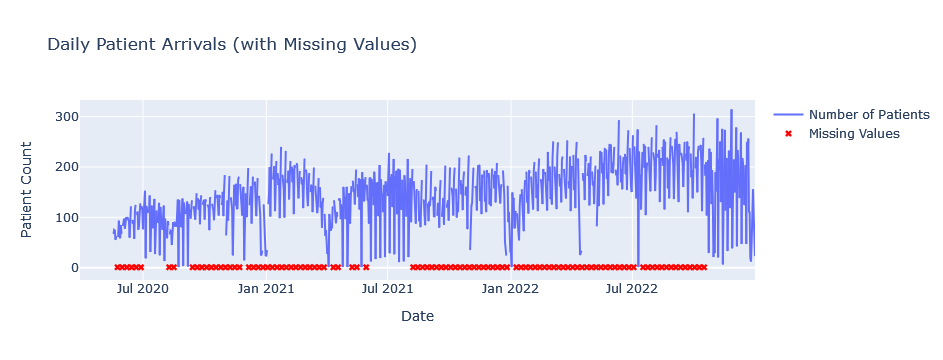

In [19]:
fig = go.Figure()

# Add scatter trace for patients
fig.add_trace(go.Scatter(x=df.index, y=df['Patients'], 
                          mode='lines', 
                          name='Number of Patients'))

# Add markers for missing values
missing_dates = df[df['Patients'].isna()].index
missing_values_trace = go.Scatter(x=missing_dates, y=[df['Patients'].min()]*len(missing_dates),
                                  mode='markers', marker=dict(color='red', symbol='x'),
                                  name='Missing Values')
fig.add_trace(missing_values_trace)

# Set plot title and axis labels
fig.update_layout(title='Daily Patient Arrivals (with Missing Values)',
                  xaxis_title='Date', yaxis_title='Patient Count')

# Show plot
fig.show()

In [20]:
missing_vals = df[df['Patients'].isna()]
missing_vals

Patients
Date                
2020-05-24       NaN
2020-05-31       NaN
2020-06-07       NaN
2020-06-14       NaN
2020-06-21       NaN
...              ...
2022-09-18       NaN
2022-09-25       NaN
2022-10-02       NaN
2022-10-09       NaN
2022-10-16       NaN

[102 rows x 1 columns]

We can see **102 missing instances** of patient arrival counts. To see the pattern of missing values, we can add a time series feature to identify which days of the week are the missing values coming from.

In [21]:
df = df.copy()
df['date'] = df.index
df['day_of_week'] = df['date'].dt.dayofweek
df.head()

Patients       date  day_of_week
Date                                        
2020-05-18      67.0 2020-05-18            0
2020-05-19      75.0 2020-05-19            1
2020-05-20      74.0 2020-05-20            2
2020-05-21      55.0 2020-05-21            3
2020-05-22      62.0 2020-05-22            4

The week numbers in the `'day_of_week'` here could be perceived as:

- `0` : `Monday`
- `1` : `Tuesday`
- `2` : `Wednesday`
- `3` : `Thursday`
- `4` : `Friday`
- `5` : `Saturday`
- `6` : `Sunday`


<Axes: xlabel='day_of_week'>

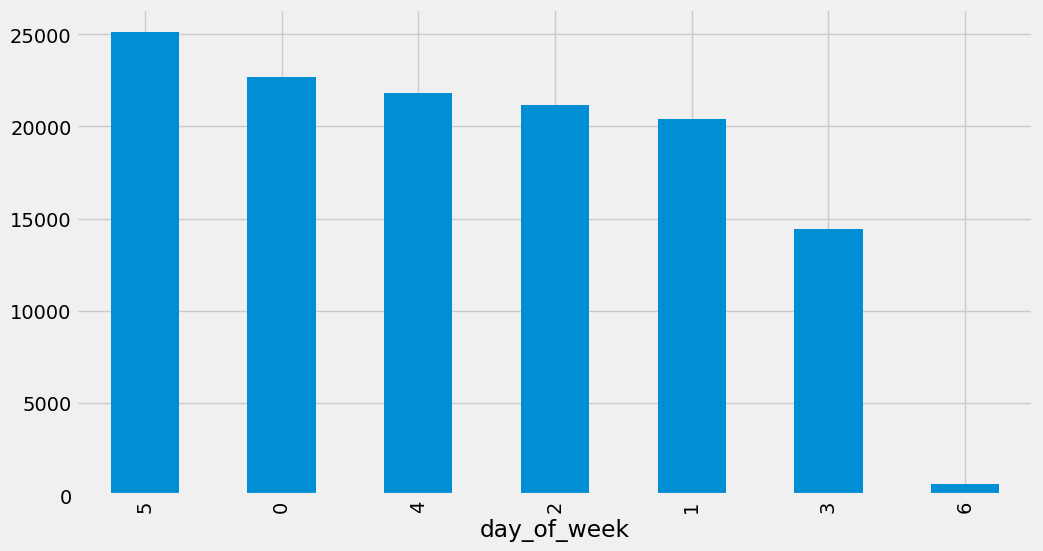

In [22]:
df.groupby('day_of_week')['Patients'].sum().sort_values(ascending=False) \
    .plot(kind='bar', figsize=(11, 6))

**Saturday** seems to be the day of the week with the **highest patient arrival counts**. Consequently, **Sunday** seems to be the one with the **lowest patient arrival counts**. What could this possibly mean?

![https://www.facebook.com/SkylineHospitalAndMedicalCenter/photos/a.944515819031784/1924894020993954/](./pictures/opening_now_on_sundays.jpg)

**Source:** [Facebook](https://www.facebook.com/SkylineHospitalAndMedicalCenter/photos/a.944515819031784/1924894020993954/)

Skyline Hospital and Medical Center has announced that starting on June 13, 2021, the outpatient unit will start to be active. This may explain why there seems to be a **weekly pattern of missing values during Sundays**, and that it seems to be the day of the week with the lowest count of patient arrival counts.

However, this would not explain why **there still seems to be Sundays with missing values**. To make our time series data seem more relevant to new data, we can **pick a point in time when the missing values have stopped**, and continue on from there. In this case, we can choose **October 17, 2022 as our new starting point**.

In [23]:
df = df.loc['2022-10-17'::]
df

Patients       date  day_of_week
Date                                        
2022-10-17     205.0 2022-10-17            0
2022-10-18     182.0 2022-10-18            1
2022-10-19     210.0 2022-10-19            2
2022-10-20     103.0 2022-10-20            3
2022-10-21     179.0 2022-10-21            4
...              ...        ...          ...
2022-12-27     114.0 2022-12-27            1
2022-12-28     156.0 2022-12-28            2
2022-12-29     105.0 2022-12-29            3
2022-12-30      24.0 2022-12-30            4
2022-12-31      23.0 2022-12-31            5

[76 rows x 3 columns]

In [24]:
df.isna().sum()

Patients       0
date           0
day_of_week    0
dtype: int64

Now we have no more missing values, and we have even cleaner data. We can now save this once again as the new dataset that we will work with. I will use the parquet file format once again to reduce memory consumption.

In [25]:
df.to_parquet('data/october_17_22_to_dec_31_22_patient_arrivals_data.parquet')

We will leave the `'date'` column for now (which is a duplicate of the old and indexed `'Date'` column) as we will need it for **feature engineering** and **model building**.

In [26]:
df['Patients'].describe()

count     76.000000
mean     160.157895
std       81.332741
min        6.000000
25%      110.750000
50%      187.000000
75%      214.000000
max      315.000000
Name: Patients, dtype: float64

### Time series decomposition

We can try to decompose the time series data to know its **trend, seasonality, and residual** components.

In [27]:
from statsmodels.tsa.seasonal import STL

In [28]:
patients_series = df['Patients']

# Perform STL decomposition
stl = STL(patients_series, seasonal=7)
result = stl.fit()
print(stl, result, sep='\n')

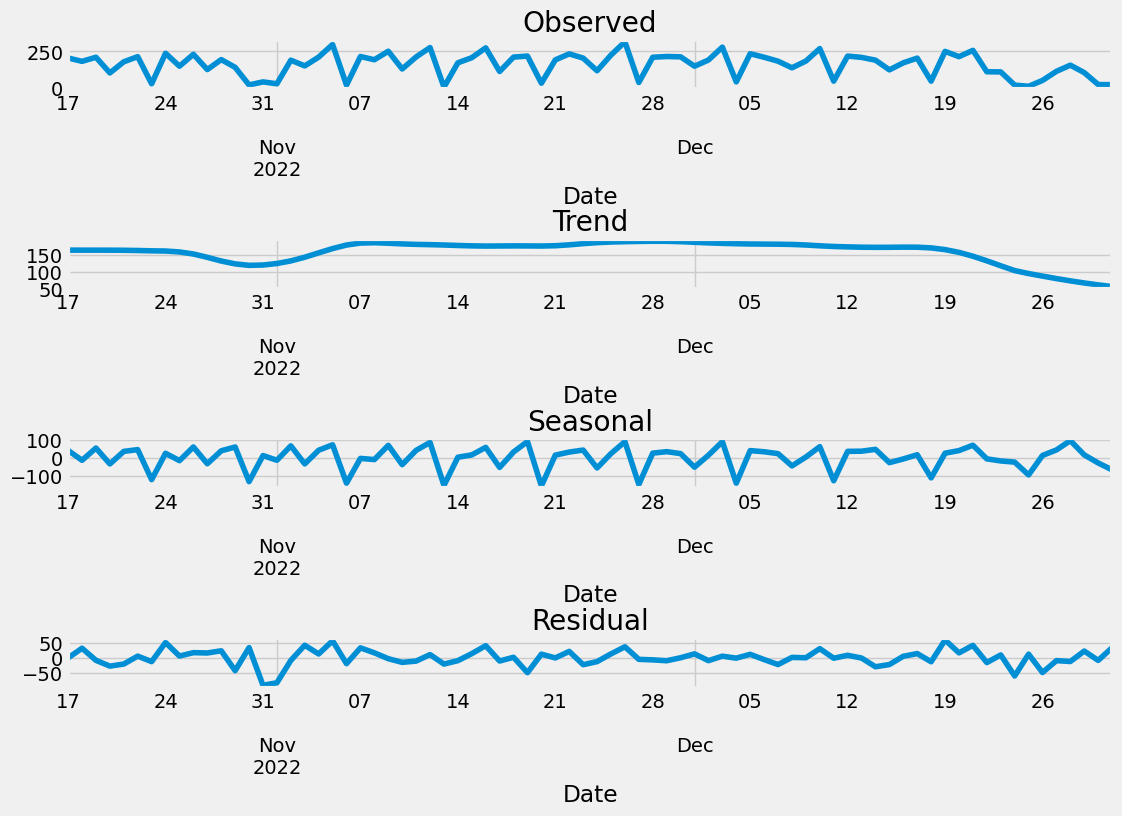

In [29]:
# Plot the components
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=3)

# Observed component
result.observed.plot(ax=ax[0], legend=False)
ax[0].set_title('Observed')

# Trend component
result.trend.plot(ax=ax[1], legend=False)
ax[1].set_title('Trend')

# Seasonal component
result.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_title('Seasonal')

# Residual component
result.resid.plot(ax=ax[3], legend=False)
ax[3].set_title('Residual')

# Show plot
plt.show()

We can see from the time series decomposition that it has no uptrend, it has some seasonality, and a fairly strong residual component.

### Outlier detection and handling

To detect and handle outliers, we will make use of the interquartile (IQR) method.

In [30]:
# Calculate the 25th and 75th quantiles and the IQR
Q1 = patients_series.quantile(0.25)
Q3 = patients_series.quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 0.1 * IQR
upper_bound = Q3 + 0.9 * IQR

print(f'Lower Bound: {lower_bound}')
print(f'Upper Bound: {upper_bound}')

Lower Bound: 100.425
Upper Bound: 306.925


In [31]:
def custom_winsorize(x):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x

cleaned_series = patients_series.copy()
cleaned_series = cleaned_series.apply(custom_winsorize)
df['Patients'] = cleaned_series.copy()

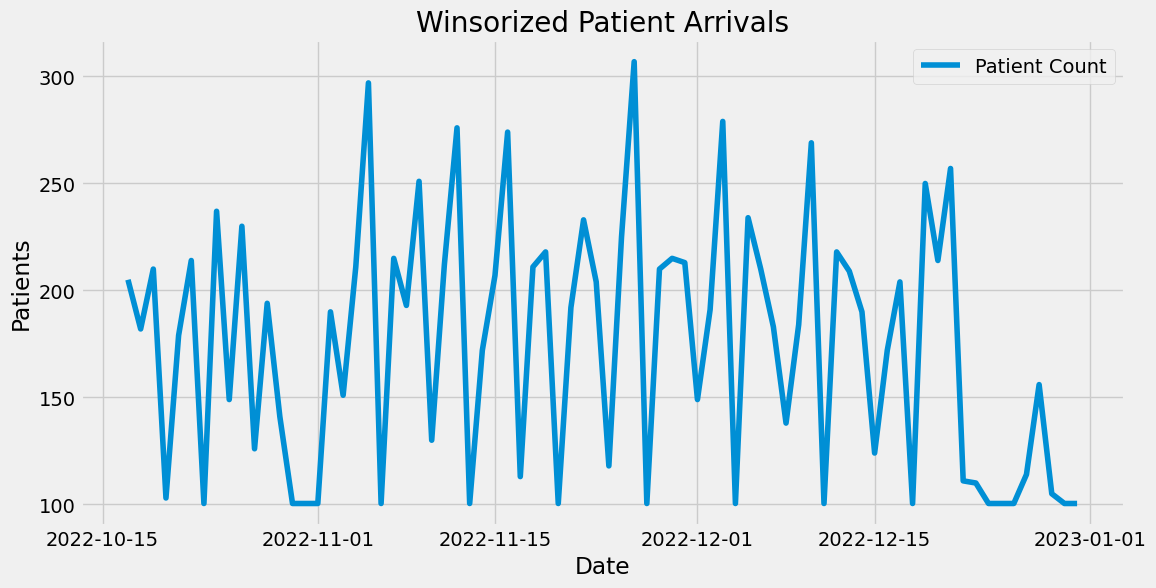

In [32]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the winsorized time series data
ax.plot(df.index, 'Patients', data=df,
       label='Patient Count')

# Plot title and labels
ax.set_title('Winsorized Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patients')

# Show legend
plt.legend()

# Show plot
plt.show()

## 4. Feature engineering

We now proceed to do feature engineering to enrich the data and try to improve model performance. We actually have already added the day of week as `'day_of_week'` column, now we will add other time series features.

In [33]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    
    window_size = 7  # 7-day rolling window
    
    # Rolling minimum
    df['rolling_min'] = df['Patients'].rolling(window=window_size).min()
    
    # Rolling maximum
    df['rolling_max'] = df['Patients'].rolling(window=window_size).max()
    
    # Rolling sum
    df['rolling_sum'] = df['Patients'].rolling(window=window_size).sum()
    
    # Rollling mean
    df['rolling_mean'] = df['Patients'].rolling(window=window_size).mean()
    
    # Rolling median
    df['rolling_median'] = df['Patients'].rolling(window=window_size).median()
    
    # Rolling standard deviation
    df['rolling_std'] = df['Patients'].rolling(window=window_size).std()
    
    # Rolling 25th percentile
    df['rolling_quantile_25'] = df['Patients'].rolling(window=window_size).quantile(0.25)
    
    # Rolling 75th percentile
    df['rolling_quantile_75'] = df['Patients'].rolling(window=window_size).quantile(0.75)

    return df

df = create_features(df)
df.dtypes

Patients                      float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
dtype: object

## 5. Model Building

Now that we have finished feature engineering, it is time to build our forecasting model. Before we actually try to build it, we first do **time series cross-validation**.

### Time series cross-validation

In [34]:
from sklearn.model_selection import TimeSeriesSplit

In [35]:
tss = TimeSeriesSplit(n_splits=5, test_size=10, gap=1)
df = df.sort_index()

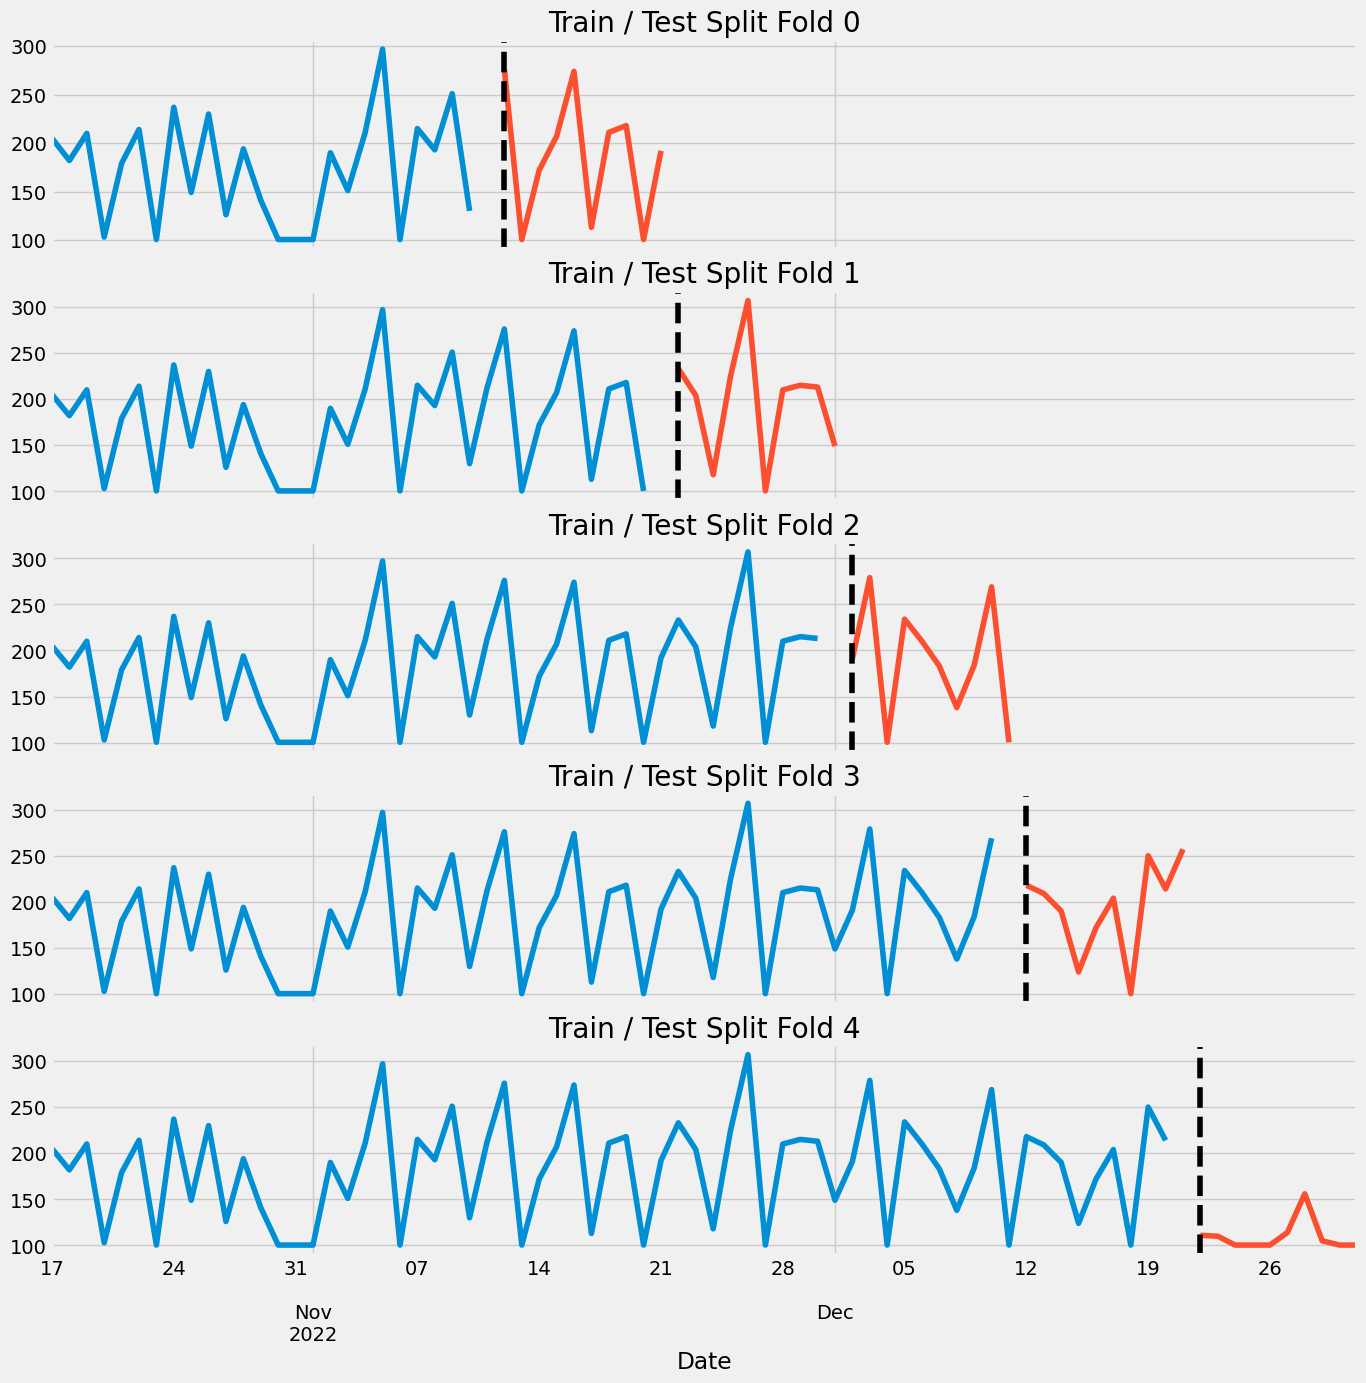

In [36]:
# Create figure and axes
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# Initalize the fold
fold = 0

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    
    train['Patients'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train / Test Split Fold {fold}')

    test['Patients'].plot(ax=axs[fold], label='Test Set')

    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

### Forecasting Horizon

In [37]:
df

Patients       date  day_of_week  month  day_of_year  rolling_min  \
Date                                                                            
2022-10-17   205.000 2022-10-17            0     10          290          NaN   
2022-10-18   182.000 2022-10-18            1     10          291          NaN   
2022-10-19   210.000 2022-10-19            2     10          292          NaN   
2022-10-20   103.000 2022-10-20            3     10          293          NaN   
2022-10-21   179.000 2022-10-21            4     10          294          NaN   
...              ...        ...          ...    ...          ...          ...   
2022-12-27   114.000 2022-12-27            1     12          361      100.425   
2022-12-28   156.000 2022-12-28            2     12          362      100.425   
2022-12-29   105.000 2022-12-29            3     12          363      100.425   
2022-12-30   100.425 2022-12-30            4     12          364      100.425   
2022-12-31   100.425 2022-12-31            5     12          365      100.425   

            rolling_max  rolling_sum  rolling_mean  rolling_median  \
Date                                                                 
2022-10-17          NaN          NaN           NaN             NaN   
2022-10-18          NaN          NaN           NaN             NaN   
2022-10-19          NaN          NaN           NaN             NaN   
2022-10-20          NaN          NaN           NaN             NaN   
2022-10-21          NaN          NaN           NaN             NaN   
...                 ...          ...           ...             ...   
2022-12-27        257.0      893.275    127.610714         110.000   
2022-12-28        156.0      792.275    113.182143         110.000   
2022-12-29        156.0      786.275    112.325000         105.000   
2022-12-30        156.0      776.700    110.957143         100.425   
2022-12-31        156.0      776.700    110.957143         100.425   

            rolling_std  rolling_quantile_25  rolling_quantile_75  
Date                                                               
2022-10-17          NaN                  NaN                  NaN  
2022-10-18          NaN                  NaN                  NaN  
2022-10-19          NaN                  NaN                  NaN  
2022-10-20          NaN                  NaN                  NaN  
2022-10-21          NaN                  NaN                  NaN  
...                 ...                  ...                  ...  
2022-12-27    57.344109              100.425                112.5  
2022-12-28    19.736428              100.425                112.5  
2022-12-29    19.975829              100.425                112.0  
2022-12-30    20.482959              100.425                109.5  
2022-12-31    20.482959              100.425                109.5  

[76 rows x 13 columns]

Now we add time lags, which will also determine how far in the future do we want to forecast. For this data, we can try to forecast for up to **2 months.** These would also be added features for our data.

In [84]:
def add_lags(df):
    """
    Create time lags for added time series features and allow the model to learn the temporal structure of the data.
    """
    target_map = df['Patients'].to_dict()
    df['lag_7_days'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_14_days'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_21_days'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag_28_days'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_30_days'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag_35_days'] = (df.index - pd.Timedelta('35 days')).map(target_map)
    df['lag_42_days'] = (df.index - pd.Timedelta('42 days')).map(target_map)
    df['lag_49_days'] = (df.index - pd.Timedelta('49 days')).map(target_map)
    df['lag_56_days'] = (df.index - pd.Timedelta('56 days')).map(target_map)
    df['lag_60_days'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    
    return df

df = add_lags(df)
df

Patients       date  day_of_week  month  day_of_year  rolling_min  \
Date                                                                            
2022-10-17   205.000 2022-10-17            0     10          290          NaN   
2022-10-18   182.000 2022-10-18            1     10          291          NaN   
2022-10-19   210.000 2022-10-19            2     10          292          NaN   
2022-10-20   103.000 2022-10-20            3     10          293          NaN   
2022-10-21   179.000 2022-10-21            4     10          294          NaN   
...              ...        ...          ...    ...          ...          ...   
2022-12-27   114.000 2022-12-27            1     12          361      100.425   
2022-12-28   156.000 2022-12-28            2     12          362      100.425   
2022-12-29   105.000 2022-12-29            3     12          363      100.425   
2022-12-30   100.425 2022-12-30            4     12          364      100.425   
2022-12-31   100.425 2022-12-31            5     12          365      100.425   

            rolling_max  rolling_sum  rolling_mean  rolling_median  ...  \
Date                                                                ...   
2022-10-17          NaN          NaN           NaN             NaN  ...   
2022-10-18          NaN          NaN           NaN             NaN  ...   
2022-10-19          NaN          NaN           NaN             NaN  ...   
2022-10-20          NaN          NaN           NaN             NaN  ...   
2022-10-21          NaN          NaN           NaN             NaN  ...   
...                 ...          ...           ...             ...  ...   
2022-12-27        257.0      893.275    127.610714         110.000  ...   
2022-12-28        156.0      792.275    113.182143         110.000  ...   
2022-12-29        156.0      786.275    112.325000         105.000  ...   
2022-12-30        156.0      776.700    110.957143         100.425  ...   
2022-12-31        156.0      776.700    110.957143         100.425  ...   

            lag_7_days  lag_14_days  lag_21_days  lag_28_days  lag_30_days  \
Date                                                                         
2022-10-17         NaN          NaN          NaN          NaN          NaN   
2022-10-18         NaN          NaN          NaN          NaN          NaN   
2022-10-19         NaN          NaN          NaN          NaN          NaN   
2022-10-20         NaN          NaN          NaN          NaN          NaN   
2022-10-21         NaN          NaN          NaN          NaN          NaN   
...                ...          ...          ...          ...          ...   
2022-12-27     214.000        209.0        210.0        215.0      100.425   
2022-12-28     257.000        190.0        183.0        213.0      210.000   
2022-12-29     111.000        124.0        138.0        149.0      215.000   
2022-12-30     110.000        172.0        184.0        191.0      213.000   
2022-12-31     100.425        204.0        269.0        279.0      149.000   

            lag_35_days  lag_42_days  lag_49_days  lag_56_days  lag_60_days  
Date                                                                         
2022-10-17          NaN          NaN          NaN          NaN          NaN  
2022-10-18          NaN          NaN          NaN          NaN          NaN  
2022-10-19          NaN          NaN          NaN          NaN          NaN  
2022-10-20          NaN          NaN          NaN          NaN          NaN  
2022-10-21          NaN          NaN          NaN          NaN          NaN  
...                 ...          ...          ...          ...          ...  
2022-12-27      233.000        207.0        193.0      100.425      194.000  
2022-12-28      204.000        274.0        251.0      190.000      141.000  
2022-12-29      118.000        113.0        130.0      151.000      100.425  
2022-12-30      225.000        211.0        212.0      211.000      100.425  
2022-12-31      306.925        

## 6. Model Training

Now we start the **model training phase**. We begin this phase by first defining the error metrics to be used for measuring the model's performance.

In [85]:
# Define error metrics

# Root mean squared error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Mean absolute percentage error (MAPE)
def mean_absolute_percentage_error(y_true,  y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Symmetric mean absolute percentage error (sMAPE)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [86]:
df.columns

Index(['Patients', 'date', 'day_of_week', 'month', 'day_of_year',
       'rolling_min', 'rolling_max', 'rolling_sum', 'rolling_mean',
       'rolling_median', 'rolling_std', 'rolling_quantile_25',
       'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days',
       'lag_28_days', 'lag_30_days', 'lag_35_days', 'lag_42_days',
       'lag_49_days', 'lag_56_days', 'lag_60_days'],
      dtype='object')

In [87]:
df.dtypes

Patients                      float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
lag_7_days                    float64
lag_14_days                   float64
lag_21_days                   float64
lag_28_days                   float64
lag_30_days                   float64
lag_35_days                   float64
lag_42_days                   float64
lag_49_days                   float64
lag_56_days                   float64
lag_60_days                   float64
dtype: object

In [92]:
tss = TimeSeriesSplit(n_splits=5, test_size=5, gap=1)
df = df.sort_index()

# Initialize the start of the fold
fold = 0

# Create empty list for the predictions
preds = []

# Make empty lists for the error metric scores
rmse_scores = []
mape_scores = []
smape_scores = []

# Initialize an empty DataFrame to store actual and predicted values
actual_vs_pred_df = pd.DataFrame()

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
                'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
                'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
                'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days']

    TARGET = 'Patients'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=400,
                           early_stopping_rounds=50,
                           tree_method='hist',
                           objective='reg:squarederror',
                           max_depth=3,
                           min_child_weight=3,
                           gamma=0,
                           learning_rate=0.01,
                           colsample_bytree=0.5,
                           subsample=0.7,
                           reg_lambda=0)

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)

    rmse_scores.append(rmse)
    mape_scores.append(mape)
    smape_scores.append(smape)

    # Store actual and predicted values along with their datetime index in the DataFrame
    temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=df.iloc[val_index].index)
    actual_vs_pred_df = pd.concat([actual_vs_pred_df, temp_df])

[0]	validation_0-rmse:189.98335	validation_1-rmse:181.18410
[100]	validation_0-rmse:75.28562	validation_1-rmse:58.88750
[200]	validation_0-rmse:34.98074	validation_1-rmse:21.28064
[287]	validation_0-rmse:22.71699	validation_1-rmse:21.97935
[0]	validation_0-rmse:190.80943	validation_1-rmse:182.85222
[100]	validation_0-rmse:75.31011	validation_1-rmse:58.21526
[200]	validation_0-rmse:34.63381	validation_1-rmse:18.27818
[300]	validation_0-rmse:21.52050	validation_1-rmse:16.96377
[303]	validation_0-rmse:21.27329	validation_1-rmse:17.10726
[0]	validation_0-rmse:189.36535	validation_1-rmse:209.80283
[100]	validation_0-rmse:74.44926	validation_1-rmse:83.59218
[200]	validation_0-rmse:34.00152	validation_1-rmse:43.77301
[300]	validation_0-rmse:21.12091	validation_1-rmse:37.74449
[395]	validation_0-rmse:16.56544	validation_1-rmse:37.91239
[0]	validation_0-rmse:189.61265	validation_1-rmse:102.05161
[100]	validation_0-rmse:74.42668	validation_1-rmse:33.33973
[122]	validation_0-rmse:61.52540	validat

In [93]:
temp_df

Actual   Predicted
Date                           
2022-12-27  114.000  131.118301
2022-12-28  156.000  132.346115
2022-12-29  105.000   91.624680
2022-12-30  100.425   99.832619
2022-12-31  100.425  115.188202

## 7. Model Evaluation

In [94]:
# Print the error metric results
print(f'RMSE across folds: {np.mean(rmse_scores):.3f}')
print(f'MAPE across folds: {np.mean(mape_scores):.3f}%')
print(f'sMAPE across folds: {np.mean(smape_scores):.3f}%')

RMSE across folds: 22.822
MAPE across folds: 12.971%
sMAPE across folds: 13.255%


In [78]:
# Display the DataFrame
actual_vs_pred_df

Actual   Predicted
Date                           
2022-12-07  183.000  205.306183
2022-12-08  138.000  141.477264
2022-12-09  184.000  201.113297
2022-12-10  269.000  235.334549
2022-12-11  100.425  105.853828
2022-12-12  218.000  194.853928
2022-12-13  209.000  204.103561
2022-12-14  190.000  192.529526
2022-12-15  124.000  141.094101
2022-12-16  172.000  191.208847
2022-12-17  204.000  260.748230
2022-12-18  100.425  114.921867
2022-12-19  250.000  217.466751
2022-12-20  214.000  212.914658
2022-12-21  257.000  206.600952
2022-12-22  111.000   81.894279
2022-12-23  110.000  101.801308
2022-12-24  100.425  126.388191
2022-12-25  100.425   62.005760
2022-12-26  100.425  112.198799
2022-12-27  114.000  131.118301
2022-12-28  156.000  132.346115
2022-12-29  105.000   91.624680
2022-12-30  100.425   99.832619
2022-12-31  100.425  115.188202

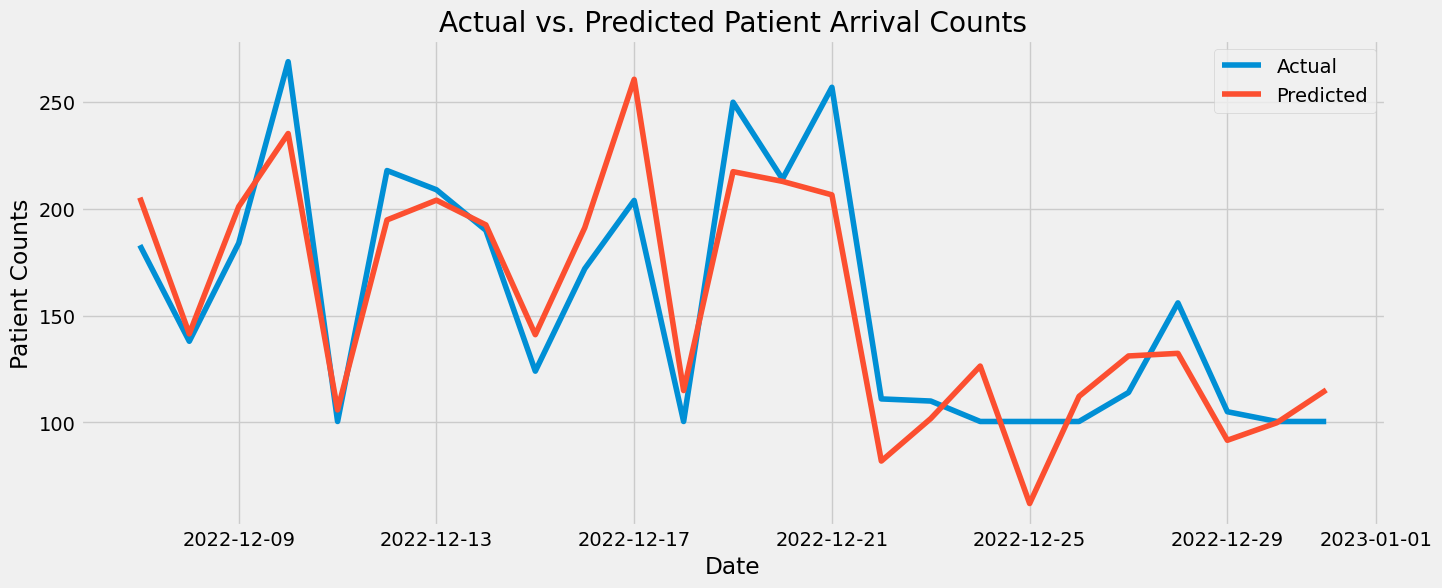

In [80]:
# Create figure
plt.figure(figsize=(15, 6))

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual')
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted')

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Patient Counts')
plt.title('Actual vs. Predicted Patient Arrival Counts')

# Show legend
plt.legend()

# Show plot
plt.show()

## 8. Forecast the future

In [95]:
# Retrain on all the data
df = create_features(df)

FEATURES = ['day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
            'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
            'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days']

TARGET = 'Patients'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=400,
                       early_stopping_rounds=50,
                       tree_method='hist',
                       objective='reg:squarederror',
                       max_depth=3,
                       min_child_weight=3,
                       gamma=0,
                       learning_rate=0.01,
                       colsample_bytree=0.5,
                       subsample=0.7,
                       reg_lambda=0)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)],
       verbose=100)


[0]	validation_0-rmse:182.16887
[100]	validation_0-rmse:72.47491
[200]	validation_0-rmse:34.21751
[300]	validation_0-rmse:21.92676
[399]	validation_0-rmse:17.21700


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [96]:
df.index.max()

Timestamp('2022-12-31 00:00:00')

In [98]:
# Create future DataFrame
future = pd.date_range(start='2022-12-31', end='2023-03-01', freq='D')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

df_and_future

Patients       date  day_of_week  month  day_of_year  rolling_min  \
2022-10-17     205.0 2022-10-17          0.0   10.0        290.0          NaN   
2022-10-18     182.0 2022-10-18          1.0   10.0        291.0          NaN   
2022-10-19     210.0 2022-10-19          2.0   10.0        292.0          NaN   
2022-10-20     103.0 2022-10-20          3.0   10.0        293.0          NaN   
2022-10-21     179.0 2022-10-21          4.0   10.0        294.0          NaN   
...              ...        ...          ...    ...          ...          ...   
2023-02-25       NaN        NaT          NaN    NaN          NaN          NaN   
2023-02-26       NaN        NaT          NaN    NaN          NaN          NaN   
2023-02-27       NaN        NaT          NaN    NaN          NaN          NaN   
2023-02-28       NaN        NaT          NaN    NaN          NaN          NaN   
2023-03-01       NaN        NaT          NaN    NaN          NaN          NaN   

            rolling_max  rolling_sum  rolling_mean  rolling_median  ...  \
2022-10-17          NaN          NaN           NaN             NaN  ...   
2022-10-18          NaN          NaN           NaN             NaN  ...   
2022-10-19          NaN          NaN           NaN             NaN  ...   
2022-10-20          NaN          NaN           NaN             NaN  ...   
2022-10-21          NaN          NaN           NaN             NaN  ...   
...                 ...          ...           ...             ...  ...   
2023-02-25          NaN          NaN           NaN             NaN  ...   
2023-02-26          NaN          NaN           NaN             NaN  ...   
2023-02-27          NaN          NaN           NaN             NaN  ...   
2023-02-28          NaN          NaN           NaN             NaN  ...   
2023-03-01          NaN          NaN           NaN             NaN  ...   

            lag_14_days  lag_21_days  lag_28_days  lag_30_days  lag_35_days  \
2022-10-17          NaN          NaN          NaN          NaN          NaN   
2022-10-18          NaN          NaN          NaN          NaN          NaN   
2022-10-19          NaN          NaN          NaN          NaN          NaN   
2022-10-20          NaN          NaN          NaN          NaN          NaN   
2022-10-21          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2023-02-25          NaN          NaN          NaN          NaN          NaN   
2023-02-26          NaN          NaN          NaN          NaN          NaN   
2023-02-27          NaN          NaN          NaN          NaN          NaN   
2023-02-28          NaN          NaN          NaN          NaN          NaN   
2023-03-01          NaN          NaN          NaN          NaN          NaN   

            lag_42_days  lag_49_days  lag_56_days  lag_60_days  isFuture  
2022-10-17          NaN          NaN          NaN          NaN     False  
2022-10-18          NaN          NaN          NaN          NaN     False  
2022-10-19          NaN          NaN          NaN          NaN     False  
2022-10-20          NaN          NaN          NaN          NaN     False  
2022-10-21          NaN          NaN          NaN          NaN     False  
...                 ...          ...          ...          ...       ...  
2023-02-25          NaN          NaN          NaN      114.000      True  
2023-02-26          NaN          NaN          NaN      156.000      True  
2023-02-27          NaN          NaN          NaN      105.000      True  
2023-02-28          NaN          NaN          NaN      100.425      True  
2023-03-01          NaN          NaN          NaN          NaN      True  

[137 rows x 24 columns]

In [100]:
future_with_features = df_and_future.query('isFuture').copy()
future_with_features

Patients date  day_of_week  month  day_of_year  rolling_min  \
2022-12-31       NaN  NaT          NaN    NaN          NaN          NaN   
2023-01-01       NaN  NaT          NaN    NaN          NaN          NaN   
2023-01-02       NaN  NaT          NaN    NaN          NaN          NaN   
2023-01-03       NaN  NaT          NaN    NaN          NaN          NaN   
2023-01-04       NaN  NaT          NaN    NaN          NaN          NaN   
...              ...  ...          ...    ...          ...          ...   
2023-02-25       NaN  NaT          NaN    NaN          NaN          NaN   
2023-02-26       NaN  NaT          NaN    NaN          NaN          NaN   
2023-02-27       NaN  NaT          NaN    NaN          NaN          NaN   
2023-02-28       NaN  NaT          NaN    NaN          NaN          NaN   
2023-03-01       NaN  NaT          NaN    NaN          NaN          NaN   

            rolling_max  rolling_sum  rolling_mean  rolling_median  ...  \
2022-12-31          NaN          NaN           NaN             NaN  ...   
2023-01-01          NaN          NaN           NaN             NaN  ...   
2023-01-02          NaN          NaN           NaN             NaN  ...   
2023-01-03          NaN          NaN           NaN             NaN  ...   
2023-01-04          NaN          NaN           NaN             NaN  ...   
...                 ...          ...           ...             ...  ...   
2023-02-25          NaN          NaN           NaN             NaN  ...   
2023-02-26          NaN          NaN           NaN             NaN  ...   
2023-02-27          NaN          NaN           NaN             NaN  ...   
2023-02-28          NaN          NaN           NaN             NaN  ...   
2023-03-01          NaN          NaN           NaN             NaN  ...   

            lag_14_days  lag_21_days  lag_28_days  lag_30_days  lag_35_days  \
2022-12-31      204.000      269.000      279.000      149.000      306.925   
2023-01-01      100.425      100.425      100.425      191.000      100.425   
2023-01-02      250.000      218.000      234.000      279.000      210.000   
2023-01-03      214.000      209.000      210.000      100.425      215.000   
2023-01-04      257.000      190.000      183.000      234.000      213.000   
...                 ...          ...          ...          ...          ...   
2023-02-25          NaN          NaN          NaN          NaN          NaN   
2023-02-26          NaN          NaN          NaN          NaN          NaN   
2023-02-27          NaN          NaN          NaN          NaN          NaN   
2023-02-28          NaN          NaN          NaN          NaN          NaN   
2023-03-01          NaN          NaN          NaN          NaN          NaN   

            lag_42_days  lag_49_days  lag_56_days  lag_60_days  isFuture  
2022-12-31      218.000      276.000      297.000      100.425      True  
2023-01-01      100.425      100.425      100.425      190.000      True  
2023-01-02      192.000      172.000      215.000      151.000      True  
2023-01-03      233.000      207.000      193.000      211.000      True  
2023-01-04      204.000      274.000      251.000      297.000      True  
...                 ...          ...          ...          ...       ...  
2023-02-25          NaN          NaN          NaN      114.000      True  
2023-02-26          NaN          NaN          NaN      156.000      True  
2023-02-27          NaN          NaN          NaN      105.000      True  
2023-02-28          NaN          NaN          NaN      100.425      True  
2023-03-01          NaN          NaN          NaN          NaN      True  

[61 rows x 24 columns]

### Feature Importance

In [101]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
feature_importance

importance
day_of_week            0.066698
month                  0.027187
day_of_year            0.035310
rolling_min            0.004840
rolling_max            0.044459
rolling_sum            0.071364
rolling_mean           0.067941
rolling_median         0.078395
rolling_std            0.035264
rolling_quantile_25    0.052239
rolling_quantile_75    0.020326
lag_7_days             0.120841
lag_14_days            0.077098
lag_21_days            0.041157
lag_28_days            0.037140
lag_30_days            0.023818
lag_35_days            0.020269
lag_42_days            0.027644
lag_49_days            0.020382
lag_56_days            0.067750
lag_60_days            0.059878

<Axes: title={'center': 'Feature Importance'}>

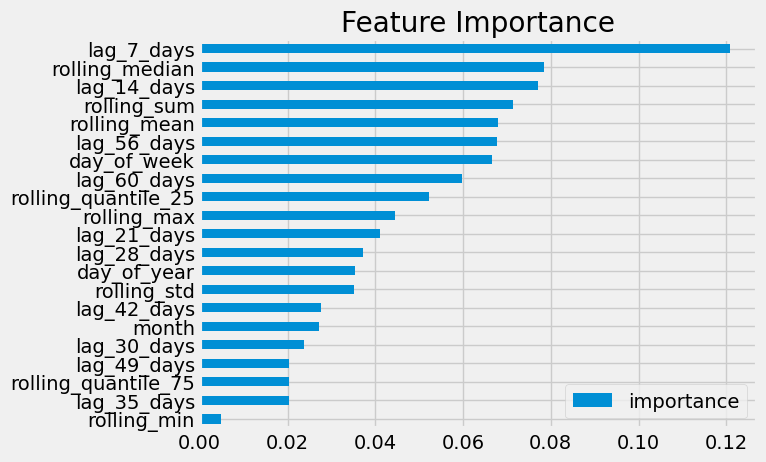

In [102]:
feature_importance \
    .sort_values('importance') \
    .plot(kind='barh', title='Feature Importance')

In [104]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])
future_with_features

Patients date  day_of_week  month  day_of_year  rolling_min  \
2022-12-31       NaN  NaT          NaN    NaN          NaN          NaN   
2023-01-01       NaN  NaT          NaN    NaN          NaN          NaN   
2023-01-02       NaN  NaT          NaN    NaN          NaN          NaN   
2023-01-03       NaN  NaT          NaN    NaN          NaN          NaN   
2023-01-04       NaN  NaT          NaN    NaN          NaN          NaN   
...              ...  ...          ...    ...          ...          ...   
2023-02-25       NaN  NaT          NaN    NaN          NaN          NaN   
2023-02-26       NaN  NaT          NaN    NaN          NaN          NaN   
2023-02-27       NaN  NaT          NaN    NaN          NaN          NaN   
2023-02-28       NaN  NaT          NaN    NaN          NaN          NaN   
2023-03-01       NaN  NaT          NaN    NaN          NaN          NaN   

            rolling_max  rolling_sum  rolling_mean  rolling_median  ...  \
2022-12-31          NaN          NaN           NaN             NaN  ...   
2023-01-01          NaN          NaN           NaN             NaN  ...   
2023-01-02          NaN          NaN           NaN             NaN  ...   
2023-01-03          NaN          NaN           NaN             NaN  ...   
2023-01-04          NaN          NaN           NaN             NaN  ...   
...                 ...          ...           ...             ...  ...   
2023-02-25          NaN          NaN           NaN             NaN  ...   
2023-02-26          NaN          NaN           NaN             NaN  ...   
2023-02-27          NaN          NaN           NaN             NaN  ...   
2023-02-28          NaN          NaN           NaN             NaN  ...   
2023-03-01          NaN          NaN           NaN             NaN  ...   

            lag_21_days  lag_28_days  lag_30_days  lag_35_days  lag_42_days  \
2022-12-31      269.000      279.000      149.000      306.925      218.000   
2023-01-01      100.425      100.425      191.000      100.425      100.425   
2023-01-02      218.000      234.000      279.000      210.000      192.000   
2023-01-03      209.000      210.000      100.425      215.000      233.000   
2023-01-04      190.000      183.000      234.000      213.000      204.000   
...                 ...          ...          ...          ...          ...   
2023-02-25          NaN          NaN          NaN          NaN          NaN   
2023-02-26          NaN          NaN          NaN          NaN          NaN   
2023-02-27          NaN          NaN          NaN          NaN          NaN   
2023-02-28          NaN          NaN          NaN          NaN          NaN   
2023-03-01          NaN          NaN          NaN          NaN          NaN   

            lag_49_days  lag_56_days  lag_60_days  isFuture        pred  
2022-12-31      276.000      297.000      100.425      True  140.992249  
2023-01-01      100.425      100.425      190.000      True  114.571686  
2023-01-02      172.000      215.000      151.000      True  153.345154  
2023-01-03      207.000      193.000      211.000      True  162.194489  
2023-01-04      274.000      251.000      297.000      True  169.990524  
...                 ...          ...          ...       ...         ...  
2023-02-25          NaN          NaN      114.000      True  155.525055  
2023-02-26          NaN          NaN      156.000      True  154.638794  
2023-02-27          NaN          NaN      105.000      True  155.525055  
2023-02-28          NaN          NaN      100.425      True  155.303345  
2023-03-01          NaN          NaN          NaN      True  155.341629  

[61 rows x 25 columns]

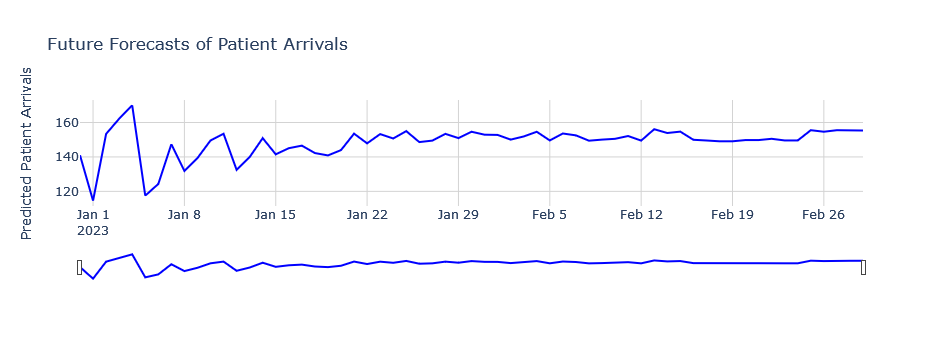

In [105]:
# Create a new figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_with_features.index, y=future_with_features['pred'],
                         name='Predicted Patient Arrivals',
                         line=dict(color='blue', width=2),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Patients</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))

fig.update_layout(
    title='Future Forecasts of Patient Arrivals',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Predicted Patient Arrivals',
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

## 9. Save the model

In [106]:
# Save the model
reg.save_model('forecast-models/xgboost_model_2.json')